In [1]:
import os
import random
import sys
import numpy as np

In [2]:
try:
  from google.colab import drive
  IS_GOOGLE_COLAB = True
except ImportError:
  IS_GOOGLE_COLAB = False

if IS_GOOGLE_COLAB:
  mount_path='/content/drive'
  base_folder = "/Data/FX"
  data_folder = f'{mount_path}/My Drive{base_folder}'
  drive.mount(mount_path)
else:
  base_folder = '../../Data/'
  data_folder = os.path.join(base_folder, "FX", "OANDA-Japan MT5 Live")

In [3]:
if IS_GOOGLE_COLAB:
  drive.mount(mount_path)
  module_path = f"{mount_path}/My Drive/modules"
else:
  module_path = '../modules'

sys.path.append(module_path)

import fprocess

In [4]:
import os
import pandas as pd

ohlc_column = ['open','high','low','close']
file_name = f"mt5_USDJPY_min30.csv"

file_path = os.path.join(data_folder, file_name)
file_path = os.path.abspath(file_path)
df = pd.read_csv(file_path, parse_dates=True, index_col=0)
df

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2014-07-07 08:30:00,102.086,102.122,102.081,102.102,738,3,0
2014-07-07 09:00:00,102.102,102.146,102.098,102.113,1036,3,0
2014-07-07 09:30:00,102.113,102.115,102.042,102.044,865,3,0
2014-07-07 10:00:00,102.047,102.052,102.005,102.019,983,3,0
2014-07-07 10:30:00,102.017,102.025,101.918,101.941,1328,3,0
...,...,...,...,...,...,...,...
2022-08-12 21:30:00,133.461,133.506,133.439,133.484,1125,3,0
2022-08-12 22:00:00,133.484,133.530,133.437,133.475,1277,3,0
2022-08-12 22:30:00,133.475,133.486,133.433,133.483,1506,3,0


# K-Means

In [301]:
columns = [*ohlc_column, "spread"]

diff_p = fprocess.DiffPreProcess(columns=ohlc_column)
ohlc_pre_process = [diff_p]
processes = [*ohlc_pre_process]

In [302]:
src_df = df[columns].copy()

for process in processes:
  src_df = process(src_df)

In [304]:
random.seed(100)
np.random.seed(100)

def k_means(src_df, label_num_k, initial_centers = None, max_iter = 10000):
  count = 0

  labels = np.fromiter(random.choices(range(label_num_k), k=src_df.shape[0]), dtype = int)
  labels_prev = np.zeros(src_df.shape[0])
  if initial_centers is None:
    cluster_centers = np.eye(label_num_k, src_df.shape[1])
  else:
    initial_centers = np.array(initial_centers)
    if initial_centers.shape == (label_num_k, src_df.shape[1]):
      cluster_centers = initial_centers
    else:
      raise ValueError("invalid initial centeers")

  while (not (labels == labels_prev).all()):
      for i in range(label_num_k):
          clusters = src_df.iloc[labels == i]
          if len(clusters) > 0:
            cluster_centers[i, :] = clusters.mean(axis = 0)
          else:
            cluster_centers[i, :] = np.ones(src_df.shape[1])
      dist = ((src_df.values[:, :, np.newaxis] - cluster_centers.T[np.newaxis, :, :]) ** 2).sum(axis = 1)
      # dist = np.sqrt(dist)
      labels_prev = labels
      labels = dist.argmin(axis = 1)
      count += 1
      if count > max_iter:
        break
  return labels, cluster_centers

In [305]:
from itertools import product

def create_binary_matrix(n, symbols:list):
    binary_combinations = list(product(symbols, repeat=n))
    binary_matrix = np.array(binary_combinations)

    return binary_matrix

n_dimension = 2
ini_centers = create_binary_matrix(n_dimension, [1.0, -1.0])

In [306]:
ini_centers = np.vstack([ini_centers, [0.0,0.0 ]])

In [307]:
labels, centers = k_means(src_df[["open", "close"]], label_num_k=len(ini_centers), initial_centers=ini_centers)

In [308]:
len(centers)

5

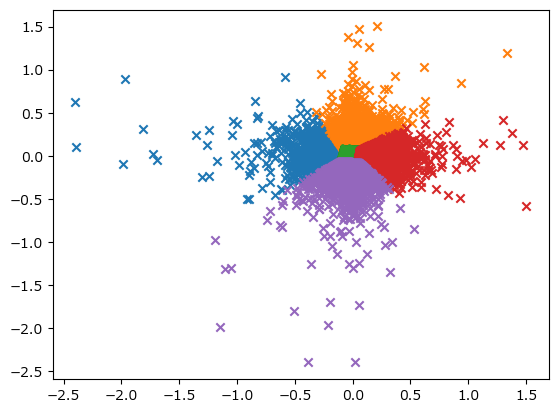

In [309]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = [*mcolors.TABLEAU_COLORS.values()]

for label in range(len(centers)):
    label_df = src_df[["open", "close"]].loc[labels == label]
    plt.scatter(label_df["open"], label_df["close"], color=colors[label], marker="x")
    plt.scatter(centers[label][0], centers[label][1], color=colors[label])
plt.show()

In [310]:
from scipy.stats import norm
from scipy.stats import multivariate_normal

def log_likelihood(label_df, center, cov):
    return multivariate_normal.logpdf(label_df, center, cov).sum()

def bic(label_df, center, cov):
    size = len(label_df)
    df = size * (label_df.shape[1] + 3) / 2
    return -2 * log_likelihood(label_df, center, cov) + df * np.log(size)

def clusters_bic(c1:pd.DataFrame, c2: pd.DataFrame, centers):
    size = len(c1) + len(c2)
    df = size * (c1.shape[1] + 3) / 2
    
    c1_cov = c1.cov()
    c2_cov = c2.cov()
    c1_center = centers[0]
    c2_center = centers[1]
    
    beta = np.linalg.norm(c1_center - c2_center) / np.sqrt(np.linalg.det(c1_cov) + np.linalg.det(c2_cov))
    alpha = 0.5 / norm.cdf(beta)
    bic = -2 * (size * np.log(alpha) + log_likelihood(c1, c1_center, c1_cov) + log_likelihood(c2, c2_center, c2_cov)) + 2 * df * np.log(size)
    return bic

In [311]:
label = 0
label_df = label_df = src_df[["open", "close"]].loc[labels == label].dropna()
center = centers[label]

In [312]:
label_bic = bic(label_df, center, label_df.cov())
label_bic

154867.1907195557

In [313]:
new_labels, new_centers = k_means(label_df, 2)

In [314]:
c1 = label_df.loc[new_labels == 0]
c2 = label_df.loc[new_labels == 1]

new_bic = clusters_bic(c1, c2, new_centers)
new_bic

339284.37418652483

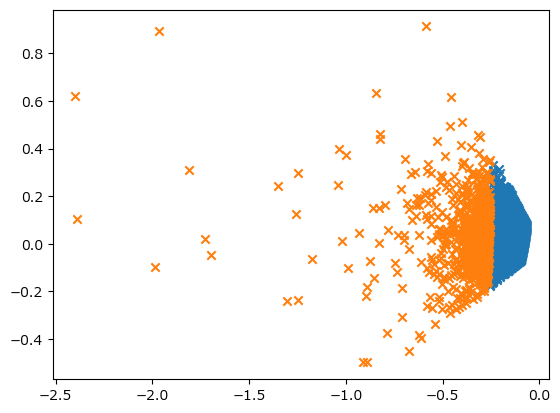

In [315]:
# Even if the data have outliers, x-means can't split it. May be it depends on initial centers though.
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
colors = [*mcolors.TABLEAU_COLORS.values()]

for label in range(len(new_centers)):
    new_label_df = label_df[["open", "close"]].loc[new_labels == label]
    plt.scatter(new_label_df["open"], new_label_df["close"], color=colors[label], marker="x")
    plt.scatter(new_centers[label][0], new_centers[label][1], color=colors[label])
plt.show()

In [316]:
n_dimension = 2
ini_centers = create_binary_matrix(n_dimension, [1.0, -1.0])

In [317]:
label_num_k = 30
divisions = [i / (label_num_k-1) for i in range(label_num_k)]
token_df = src_df[["open", "close"]].dropna()
ini_centers = [
    np.quantile(token_df, p, axis=0) for p in divisions
]

In [318]:
labels, centers = k_means(token_df, label_num_k=len(ini_centers), initial_centers=ini_centers)

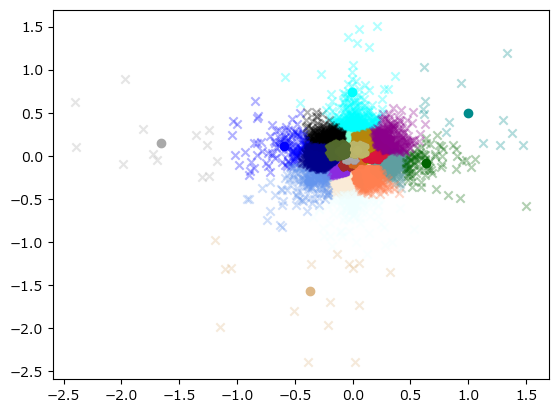

In [319]:
colors = [*mcolors.CSS4_COLORS.values()]

for label in range(len(centers)):
    label_df = token_df.loc[labels == label]
    plt.scatter(label_df["open"], label_df["close"], color=colors[label], marker="x", alpha=0.3)
    plt.scatter(centers[label][0], centers[label][1], color=colors[label])
plt.show()

In [183]:
def random_token():
    return np.random.random(2) * 2 - 1

In [210]:
token = random_token()
token

array([0.27650911, 0.13871101])

In [320]:
def to_label(token, centers):
    if len(token.shape) == 1:
        token = np.reshape(token, (1, token.shape[0]))
    dist = ((token - centers) ** 2).sum(axis = 1)
    label = dist.argmin(axis = 0)
    return label

In [260]:
label = to_label(token, centers)
label

27

In [239]:
center = centers[label]
c_diff = label_df - center
mean = c_diff.mean()
std = c_diff.std()
l_min = c_diff.min()
l_max = c_diff.max()

In [240]:
c_diff.describe()

,open,close
count,1.313000e+03,1.313000e+03
mean,2.743849e-17,-2.536686e-19
std,2.441649e-02,2.593287e-02
min,-5.114027e-02,-7.749522e-02
25%,-1.831976e-02,-1.747983e-02
50%,-1.909505e-03,7.654823e-03
75%,1.706485e-02,2.099158e-02
max,8.321870e-02,3.638014e-02


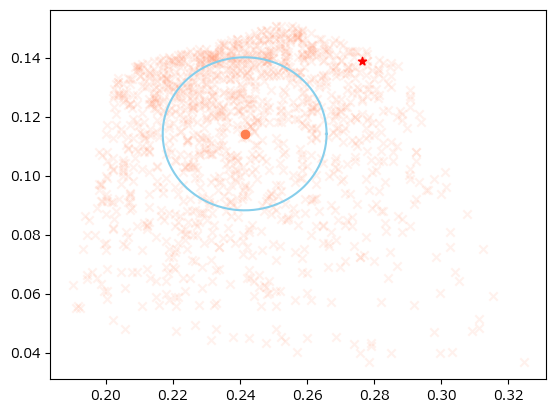

In [245]:
# we can't revert labl to values.
theta = np.linspace(0, 2*np.pi, 100)

x_circle = center[0] + std["open"] * np.cos(theta)
y_circle = center[1] + std["close"] * np.sin(theta)

plt.scatter(label_df["open"], label_df["close"], color=colors[label], marker="x", alpha=0.1)
plt.plot(x_circle, y_circle,  color='skyblue')
plt.scatter(center[0], center[1], color=colors[label])
plt.scatter(token[0], token[1], color="r", marker="*")
plt.show()

In [321]:
def to_labels(token, centers):
    dist = ((token - centers) ** 2).sum(axis = 1)
    label = dist.argmin(axis = 0)
    return label

In [322]:
observations = token_df.iloc[:60]

In [323]:
prediction = token_df.iloc[60:70]

In [324]:
def to_labels(predictions, centers):
    if isinstance(predictions, pd.DataFrame):
        predictions = predictions.values
    dist = ((predictions[:, :, np.newaxis] - centers.T[np.newaxis, :, :]) ** 2).sum(axis = 1)
    labels = dist.argmin(axis = 1)
    return labels

In [325]:
pre_labels = to_labels(prediction, centers)
pre_labels

array([11, 11,  5, 26, 15, 18,  0,  0, 26,  0], dtype=int64)

In [326]:
def to_density_params(df, labels, centers):
    params = []
    for label in range(len(centers)):
        label_df = df.loc[labels==label]
        center = centers[label]
        c_diff = label_df - center
        mean = c_diff.mean().values
        std = c_diff.std().values
        l_min = c_diff.min().values
        l_max = c_diff.max().values
        params.append([label, center[0], center[1], mean[0], mean[1], std[0], std[1], l_min[0], l_min[1], l_max[0], l_max[1]])
    params_df = pd.DataFrame(params, columns=["label", "cx", "cy", "meanx", "meany", "stdx", "stdy", "minx", "miny", "maxx", "maxy"])
    return params_df

In [327]:
params_df = to_density_params(token_df, labels, centers)

In [328]:
params_df

,label,cx,cy,meanx,meany,stdx,stdy,minx,miny,maxx,maxy
0,0,0.017144,0.011691,-4.887822e-19,1.557993e-18,0.013085,0.014492,-0.027144,-0.027691,0.030856,0.034309
1,1,-0.058654,-0.269570,4.126264e-18,6.060451e-18,0.058151,0.058719,-0.153346,-0.172430,0.111654,0.086570
2,2,0.016196,0.318590,3.845652e-18,4.146616e-17,0.073554,0.070668,-0.217196,-0.095590,0.239804,0.222410
3,3,-0.027047,0.136443,-1.469521e-19,2.351233e-18,0.031829,0.033721,-0.085953,-0.044443,0.059047,0.110557
4,4,0.001802,-0.601645,-1.433656e-18,3.945421e-17,0.136936,0.156784,-0.345802,-0.542355,0.525198,0.177645
5,5,-0.078042,-0.006545,-5.492397e-18,-3.974761e-19,0.023337,0.020930,-0.083958,-0.054455,0.030042,0.044545
6,6,0.108342,-0.071093,-1.581365e-17,-6.534568e-18,0.031677,0.029557,-0.053342,-0.079907,0.084658,0.054093
7,7,-0.200096,0.176749,1.472745e-17,3.398642e-18,0.065358,0.062393,-0.204904,-0.092749,0.105096,0.337251
8,8,0.007842,-0.131410,1.171739e-18,1.275894e-17,0.031674,0.029881,-0.075842,-0.091590,0.077158,0.046410
9,9,-0.590181,0.112560,-1.531342e-17,-3.469447e-18,0.157401,0.155031,-0.452819,-0.331560,0.187181,0.522440


In [550]:
params_df["label"].values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int64)

[]

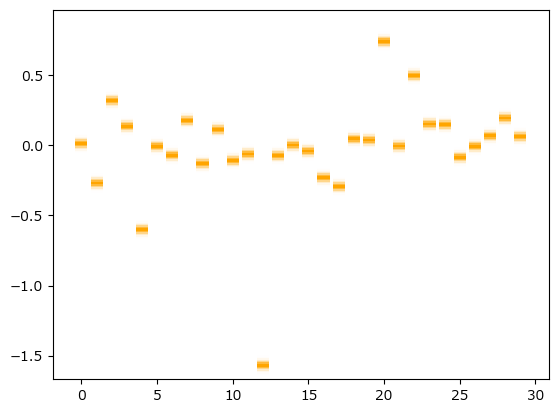

In [554]:
bin_edges = [step/100 for step in range(-10, 11)]

for label in params_df["label"].values:
    param_df = params_df[params_df["label"]==label]
    center = (param_df["cx"].iloc[0], param_df["cy"].iloc[0])
    mean = (param_df["meanx"].iloc[0], param_df["meany"].iloc[0])
    std = (param_df["stdx"].iloc[0], param_df["stdy"].iloc[0])

    density = np.array([
        norm.cdf(bin_edges[edge_i + 1], mean, std) - norm.cdf(bin_edges[edge_i], mean, std)
        for edge_i in range(len(bin_edges) -1)
    ])
    actual_edges = bin_edges + np.array(np.reshape(center, (2,1)))
    
    for index, edge in enumerate(actual_edges[1][:-1]):
        d = scaled_density[index]
        y_low = edge
        height = 0.01
        plt.bar([label], bottom=y_low, height=height, alpha=d, color="orange")
plt.plot()

In [556]:
label = pre_labels[1]
label

11

In [557]:
param_df = params_df[params_df["label"]==label]
center = (param_df["cx"].iloc[0], param_df["cy"].iloc[0])
mean = (param_df["meanx"].iloc[0], param_df["meany"].iloc[0])
std = (param_df["stdx"].iloc[0], param_df["stdy"].iloc[0])

In [558]:
bin_edges = [step/100 for step in range(-10, 11)]

density = np.array([
norm.cdf(bin_edges[edge_i + 1], mean, std) - norm.cdf(bin_edges[edge_i], mean, std)
 for edge_i in range(len(bin_edges) -1)
])

In [559]:
observations.iloc[-1]

open    -0.022
close   -0.024
Name: 2014-07-08 14:30:00, dtype: float64

In [560]:
actual_edges = bin_edges + np.array(np.reshape(center, (2,1)))

In [561]:
actual_edges[1, 1:]

array([-0.15228938, -0.14228938, -0.13228938, -0.12228938, -0.11228938,
       -0.10228938, -0.09228938, -0.08228938, -0.07228938, -0.06228938,
       -0.05228938, -0.04228938, -0.03228938, -0.02228938, -0.01228938,
       -0.00228938,  0.00771062,  0.01771062,  0.02771062,  0.03771062])

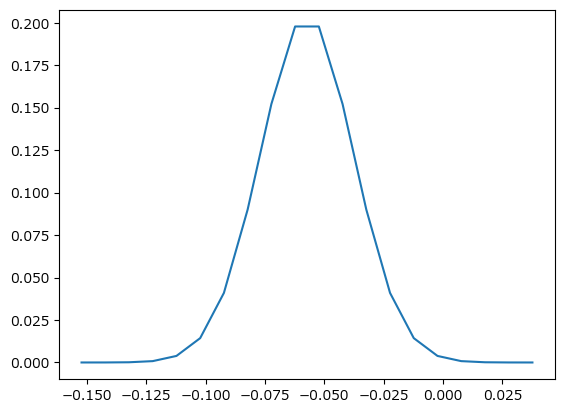

In [562]:
plt.plot(actual_edges[1, 1:], np.array(density)[:, 1])

In [563]:
def minimax(values, min_value, max_value, scale=(0, 1)):
    std = (values - min_value) / (max_value - min_value)
    scaled = std * (scale[1] - scale[0]) + scale[0]
    return scaled

scaled_density = minimax(density[:, 1], density[:, 1].min(), density[:, 1].max())

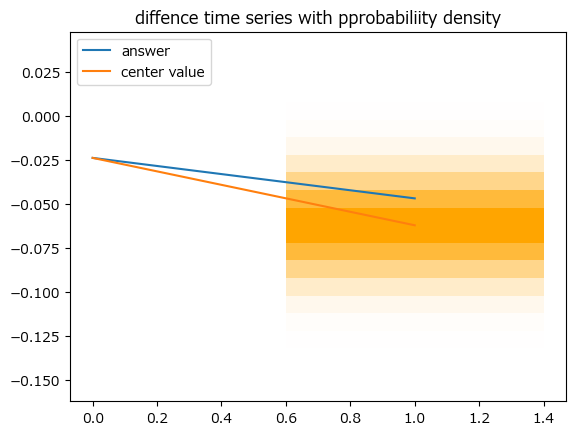

In [564]:
close = observations.iloc[-1]["close"]
pre_close = np.array(center)[1]
actual_close = prediction.iloc[0]["close"]
plt.plot([0, 1], [close, actual_close], label="answer")
plt.plot([0, 1], [close, pre_close], label="center value")
for index, edge in enumerate(actual_edges[1][:-1]):
    d = scaled_density[index]
    y_low = edge
    height = 0.01
    plt.bar([1], bottom=y_low, height=height, alpha=d, color="orange")
plt.title("diffence time series with pprobabiliity density")
plt.legend()
plt.show()

In [543]:
label_index = 2
next_label = pre_labels[label_index]

param_df = params_df[params_df["label"]==next_label]
next_center = (param_df["cx"].iloc[0], param_df["cy"].iloc[0])
next_mean = (param_df["meanx"].iloc[0], param_df["meany"].iloc[0])
next_std = (param_df["stdx"].iloc[0], param_df["stdy"].iloc[0])

next_density = np.array([
    norm.cdf(bin_edges[edge_i + 1], mean, std) - norm.cdf(bin_edges[edge_i], mean, std)
    for edge_i in range(len(bin_edges) -1)
])
next_actual_edges = bin_edges + np.array(np.reshape(next_center, (2,1)))

In [544]:
next_density_edges =  np.add.outer(actual_edges[1], next_actual_edges[1])

In [545]:
density[:, 0]

array([6.20241035e-06, 4.87755122e-05, 3.04879485e-04, 1.51497012e-03,
       5.98534645e-03, 1.88034673e-02, 4.69782809e-02, 9.33482023e-02,
       1.47534865e-01, 1.85474330e-01, 1.85474330e-01, 1.47534865e-01,
       9.33482023e-02, 4.69782809e-02, 1.88034673e-02, 5.98534645e-03,
       1.51497012e-03, 3.04879485e-04, 4.87755122e-05, 6.20241035e-06])

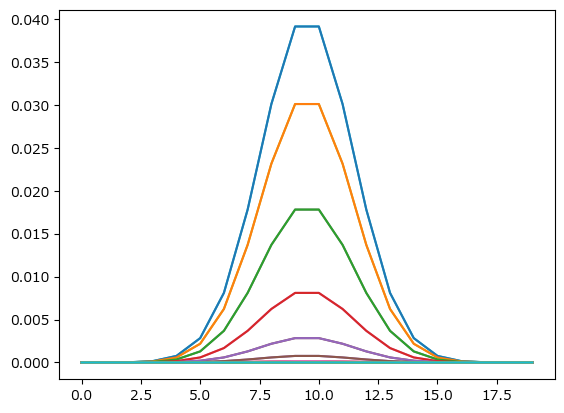

In [546]:
next_close_density = np.outer(density[:, 1], next_density[:, 1])

plt.plot(next_close_density)
plt.show()

In [547]:
next_close_density.sum()

0.9999995569999676

In [548]:
next_scaled_density = minimax(next_density[:,1], next_density[:,1].min(), next_density[:,1].max())

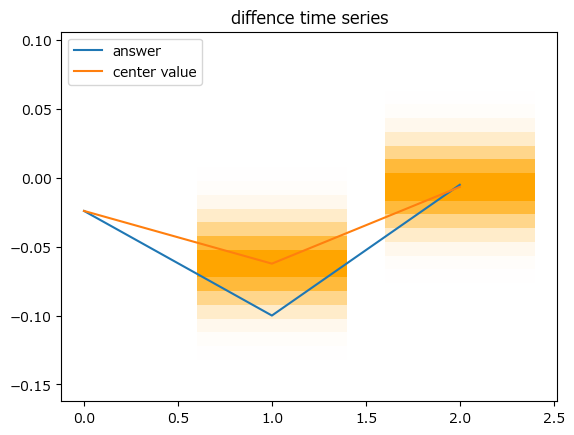

In [549]:
close = observations.iloc[-1]["close"]
pre_close = [center[1], next_center[1]]
actual_close = prediction.iloc[1:3]["close"].values
plt.plot([0, 1, 2], [close, *actual_close], label="answer")
plt.plot([0, 1, 2], [close, *pre_close], label="center value")
for index, edge in enumerate(actual_edges[1][:-1]):
    d = scaled_density[index]
    y_low = edge
    height = 0.01
    plt.bar([1], bottom=y_low, height=height, alpha=d, color="orange")
# for edge_index, edges in enumerate(next_density_edges[:-1]):
#     for index, edge in enumerate(edges[:-1]):
#         d = next_scaled_density[edge_index][index]
#         y_low = edge
#         height = 0.01
#         plt.bar([2], bottom=y_low, height=height, alpha=d, color="orange")
for index, edge in enumerate(next_actual_edges[1][:-1]):
    d = next_scaled_density[index]
    y_low = edge
    height = 0.01
    plt.bar([2], bottom=y_low, height=height, alpha=d, color="orange")
plt.title("diffence time series")
plt.legend()
plt.show()

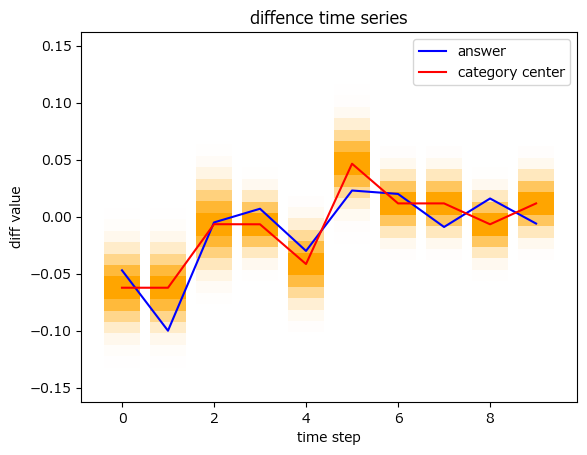

In [579]:
bin_edges = [step/100 for step in range(-10, 11)]
pre_closes = []

indices = [*range(len(pre_labels))]
for index in indices:
    label = pre_labels[index]
    param_df = params_df[params_df["label"]==label]
    center = (param_df["cx"].iloc[0], param_df["cy"].iloc[0])
    mean = (param_df["meanx"].iloc[0], param_df["meany"].iloc[0])
    std = (param_df["stdx"].iloc[0], param_df["stdy"].iloc[0])
    pre_closes.append(center[1])

    density = np.array([
        norm.cdf(bin_edges[edge_i + 1], mean, std) - norm.cdf(bin_edges[edge_i], mean, std)
        for edge_i in range(len(bin_edges) -1)
    ])
    actual_edges = bin_edges + np.array(np.reshape(center, (2,1)))
    scaled_density = minimax(density[:, 1], density[:, 1].min(), density[:, 1].max())
    
    for i, edge in enumerate(actual_edges[1][:-1]):
        d = scaled_density[i]
        y_low = edge
        height = 0.01
        plt.bar([index], bottom=y_low, height=height, alpha=d, color="orange")

plt.plot(indices, prediction["close"].values, color="blue", label="answer")
plt.plot(indices, pre_closes, color="red", label="category center")
plt.legend()
plt.title("diffence time series")
plt.ylabel("diff value")
plt.xlabel("time step")
plt.show()

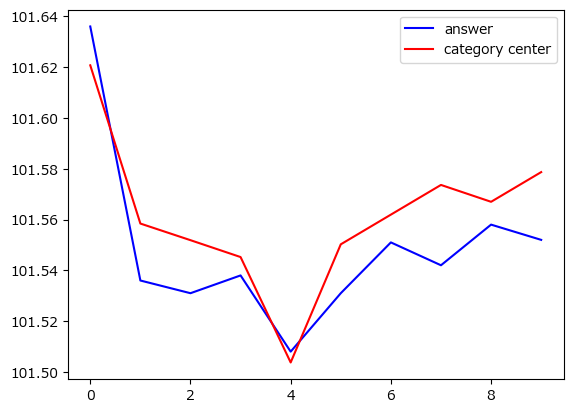

In [586]:
ini_value = df["close"].iloc[60]
plt.plot(indices, ini_value + np.cumsum(prediction["close"].values), color="blue", label="answer")
plt.plot(indices, ini_value + np.cumsum(pre_closes), color="red", label="category center")
plt.legend()
plt.show()